# ENSF 519.01 Applied Data Science 
**Assignment 2** - 100 marks

**Due:** October 18th, 04.00 pm.


**IMPORTANT NOTE: each task must be implemented as asked, even if there are other easier or better solutions.**

**How to deliver:**
Edit this file and write your solutions in sections specified with `# Your solution`. Test your code and when you are done, submit this notebook as an `.ipynb` file to D2L dropbox. 



## Problem 1 - Most popular movies (55 points)
In this assigment we want to do some basic data analysis on the most popular movies on IMDb right now. We do this in steps: first we take the list of most popular movies then we gather more informaion on each movie from the movie's page. These info are stored in pandas dataframes. Next we need to combine the information from these two tables, using pandas `merge` method. The resulting merged table might give us some insight on why some movies get more popular. Let's try and see what we can get!

Complete the `get_page_html` function below so that it gets the HTML content of any given url. We get the HTML content and store it in a variable just once, because:
1. Downloading the web page content takes ~1-2 seconds. While you're writing the html parser code you need to run and test your code many many times. If you download the whole page everytime you want to test the parser, these download times add up to significantly slow you down.
2. Making a lot of requests to the same page of a website in a short period of time might make the firewall suspicious of an attack and block your IP address

In [10]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import re

page_url = 'https://www.imdb.com/chart/top'

def get_page_html(url):
    return requests.get(url, headers = {"Accept-Language": "en-US"}).text
    
top_movies_html = get_page_html(page_url)

Parse the HTML content above using Beautiful Soup to extract these data:

* Rank (`rank`: int) **set this column as the index**
* Name of the movie (`name`: str) 
* Its release year (`release_year`: int)
* Rating (`rating`: float)
* link to its detail page (`detail_url`: str)

Store these in a pandas dataframe. The suggested column names and data types are specified in the parentheses above (20 points).

In [11]:
def get_top_movies(top_movies_page_html):    
    parser = BeautifulSoup(top_movies_page_html, 'html.parser')
    table = parser.find('table', {'class': 'chart'})
    numCols = 0
    numRows = 0
    colHeads = ['rank','name', 'release_year', 'rating', 'detail_url']
    
    for row in table.find_all('tr'):
        tds = row.find_all('td', ['titleColumn', 'imdbRating'])

        if len(tds) > 0:
            numRows += 1
            if numCols == 0:
                numCols = len(tds)

    columns = colHeads if len(colHeads) > 0 else range(0,numCols)
    df = pd.DataFrame(columns = columns, index= range(0,numRows))

    rowMarker = 0
    for row in table.find_all('tr'):
        columns = row.find_all('td', ['titleColumn', 'imdbRating'])
        for i in range(len(columns)):
            colText = columns[i].get_text().strip().replace('\n', ' ').replace('\r', '')
            if (i == 0):
                (rank, title, year) = re.match('(\d+)\.\s(.*\s)\((\d{4})', colText).groups()
                url = 'https://imdb.com' + columns[i].findAll('a')[0].get('href')
                df.loc[rowMarker] = [int(rank), title.strip(), int(year), 0, url]
            else:
                df.iloc[rowMarker, -2] = float(colText)
        if len(columns) > 0:
            rowMarker += 1
    df = df.astype({'name': 'str', 'rating': 'float64', 'detail_url': 'str', 'release_year': 'int64'})
    return df.set_index('rank')

top_movies = get_top_movies(top_movies_html)
top_movies  # Rank must be the index, the rows should match the webpage

,name,release_year,rating,detail_url
rank,,,,
1,The Shawshank Redemption,1994,9.2,https://imdb.com/title/tt0111161/
2,The Godfather,1972,9.1,https://imdb.com/title/tt0068646/
3,The Godfather: Part II,1974,9.0,https://imdb.com/title/tt0071562/
4,The Dark Knight,2008,9.0,https://imdb.com/title/tt0468569/
5,12 Angry Men,1957,8.9,https://imdb.com/title/tt0050083/
...,...,...,...,...
246,Infernal Affairs,2002,8.0,https://imdb.com/title/tt0338564/
247,Aladdin,1992,8.0,https://imdb.com/title/tt0103639/
248,The Battle of Algiers,1966,8.0,https://imdb.com/title/tt0058946/


Now we proceed to step 2, we want to create a function that parses each individual movie's page. Just like the previous assignment on regular expressions, we try to get that working on one sample and only after we made sure that everything works properly we use a loop to get all the data that we need. 

In [12]:
avengers_url = 'https://imdb.com/title/tt4154796/'
avengers_html = get_page_html(avengers_url) 

Make a function that parses the html content of a movie details page and extracts these information:

* Movie length in minutes (int)
* Release date (convert the string to a python date object - use [`strptime` built-in function](https://www.programiz.com/python-programming/datetime/strptime) or regular expressions as you wish)
* List of genres (list of strings)
* Budget (int), if unavailable: ignore.
* Name of the directors (list)

Return these as a dictionary. You can extract more data as you wish. (20 points)

In [13]:
import re
from datetime import datetime

def extract_movie_details(html):
    parser = BeautifulSoup(html, 'html.parser')
    subtxt = parser.find('div', {'class': 'subtext'})
    subtxtLinks = subtxt.findAll('a')
    
    genres = []
    for item in range(len(subtxtLinks) - 1):
        genres.append(subtxtLinks[item].get_text())
        
    releaseDateTxt = subtxtLinks[-1].get_text().split()
    del releaseDateTxt[-1]
    releaseDateTxt = ' '.join(releaseDateTxt)
    try:
        release_date = datetime.strptime(releaseDateTxt, '%d %B %Y')
    except:
        try:
            release_date = datetime.strptime(releaseDateTxt, '%B %Y')
        except:
            try:
                release_date = datetime.strptime(releaseDateTxt, '%Y')
            except:
                release_date = None
    
    creditSum = parser.find('div', {'class': 'credit_summary_item'}).findAll('a')
    directors = []
    for item in range(len(creditSum)):
        directors.append(creditSum[item].get_text())
    
    try:
        budgetTag = parser.find('h4', text='Budget:').next_sibling.string
        budget = int(re.sub(r'[^\d.]', '', budgetTag))
        if not re.search('\$', budgetTag):
            converter_url = 'https://free.currconv.com/api/v7/convert?q='
            compression = '&compact=ultra&'
            key = 'apiKey=461782f2ee688422d26b'
            (currency, ) = re.match('^(\S{3})\d', budgetTag).groups()
            conversion = currency + '_' + 'USD'
            fullUrl = converter_url + conversion + compression + key
            response = requests.get(fullUrl).json()
            rate = response[conversion]
            budget = budget * rate
    except:
        budget = None
    
    try:
        lengthStr = parser.find('h4', text='Runtime:').find_next('time').get_text()
        (mins,) = re.match('(\d+)\s', lengthStr).groups()
        length = int(mins)
    except:
        try:
            unformattedLength = subtxt.find('time').get_text().strip()
            (hour, mins) = re.match('(\d+)\S\s(\d+)\S', unformattedLength).groups()
            length = int(hour) * 60 + int(mins)
        except:
            length = None
    
    return {'length':length, 'genres':genres, 'release_date':release_date, 'budget':budget, 'directors':directors}
    
    
avengers_data = extract_movie_details(avengers_html)
print(avengers_data) 
# Expected: {
#     'length': 181, 
#     'genres': ['action', 'adventure', 'sci-fi'], 
#     'release_date': datetime.datetime(2019, 4, 26, 0, 0),
#     'budget': 356000000,
#     'directors': ['Anthony Russo', 'Joe Russo']
# }

{'length': 181, 'genres': ['Action', 'Adventure', 'Sci-Fi'], 'release_date': datetime.datetime(2019, 4, 26, 0, 0), 'budget': 356000000, 'directors': ['Anthony Russo', 'Joe Russo']}


Now get the list of detail page urls for all the movies:

In [14]:
urls = top_movies.set_index('name')['detail_url']
urls

name
The Shawshank Redemption    https://imdb.com/title/tt0111161/
The Godfather               https://imdb.com/title/tt0068646/
The Godfather: Part II      https://imdb.com/title/tt0071562/
The Dark Knight             https://imdb.com/title/tt0468569/
12 Angry Men                https://imdb.com/title/tt0050083/
                                          ...                
Infernal Affairs            https://imdb.com/title/tt0338564/
Aladdin                     https://imdb.com/title/tt0103639/
The Battle of Algiers       https://imdb.com/title/tt0058946/
Drishyam                    https://imdb.com/title/tt4430212/
Castle in the Sky           https://imdb.com/title/tt0092067/
Name: detail_url, Length: 250, dtype: object

and loop through the movie name and urls created above (`urls`), use `extract_movie_details` and create a data frame out of the dictionaries. The dataframe should have a column storing the movie name and one column for each item in the dictionary (length, genres, ...). If any piece of data was not availble for a movie (e.g. budget might not be available for some) just leave it, pandas will use `NaN` for that cell. (10 points)

In [15]:
dicts = []

indexes = urls.index
for index in range(len(urls)):
    html = get_page_html(urls[index]) 
    movieData = extract_movie_details(html)
    movieData['name'] = indexes[index]
    dicts.append(movieData)
    
movieDf = pd.DataFrame(dicts).set_index('name')
movieDf

,length,genres,release_date,budget,directors
name,,,,,
The Shawshank Redemption,142,[Drama],1994-10-14,25000000.0,[Frank Darabont]
The Godfather,175,"[Crime, Drama]",1972-03-24,6000000.0,[Francis Ford Coppola]
The Godfather: Part II,202,"[Crime, Drama]",1974-12-20,13000000.0,[Francis Ford Coppola]
The Dark Knight,152,"[Action, Crime, Drama]",2008-07-18,185000000.0,[Christopher Nolan]
12 Angry Men,96,[Drama],1957-04-10,350000.0,[Sidney Lumet]
...,...,...,...,...,...
Infernal Affairs,101,"[Crime, Drama, Mystery]",NaT,6428966.0,"[Andrew Lau, Alan Mak]"
Aladdin,90,"[Animation, Adventure, Comedy]",1992-11-25,28000000.0,"[Ron Clements, John Musker]"
The Battle of Algiers,121,"[Drama, War]",1967-09-20,800000.0,[Gillo Pontecorvo]


Use pandas' `merge` method to join these two tables into one. Merge on movie name. (5 points)

In [17]:
merged = pd.merge(
    top_movies,
    movieDf,
    on = 'name',
)
merged

,name,release_year,rating,detail_url,length,genres,release_date,budget,directors
0,The Shawshank Redemption,1994,9.2,https://imdb.com/title/tt0111161/,142,[Drama],1994-10-14,25000000.0,[Frank Darabont]
1,The Godfather,1972,9.1,https://imdb.com/title/tt0068646/,175,"[Crime, Drama]",1972-03-24,6000000.0,[Francis Ford Coppola]
2,The Godfather: Part II,1974,9.0,https://imdb.com/title/tt0071562/,202,"[Crime, Drama]",1974-12-20,13000000.0,[Francis Ford Coppola]
3,The Dark Knight,2008,9.0,https://imdb.com/title/tt0468569/,152,"[Action, Crime, Drama]",2008-07-18,185000000.0,[Christopher Nolan]
4,12 Angry Men,1957,8.9,https://imdb.com/title/tt0050083/,96,[Drama],1957-04-10,350000.0,[Sidney Lumet]
...,...,...,...,...,...,...,...,...,...
247,Guardians of the Galaxy,2014,8.0,https://imdb.com/title/tt2015381/,121,"[Action, Adventure, Comedy]",2014-08-01,170000000.0,[James Gunn]
248,Infernal Affairs,2002,8.0,https://imdb.com/title/tt0338564/,101,"[Crime, Drama, Mystery]",NaT,6428966.0,"[Andrew Lau, Alan Mak]"
249,Aladdin,1992,8.0,https://imdb.com/title/tt0103639/,90,"[Animation, Adventure, Comedy]",1992-11-25,28000000.0,"[Ron Clements, John Musker]"
250,The Battle of Algiers,1966,8.0,https://imdb.com/title/tt0058946/,121,"[Drama, War]",1967-09-20,800000.0,[Gillo Pontecorvo]


# Problem 2 - Visualizing and Analysing (45 points)

Now, we have a data frame containing information about the most popular IMDb movies as of now. In this part we are going to use matplotlib to visualize those data and see if we can find any meaningful features that can predict success of a movie. 

This problem uses the results of the problem 1. If you can't do Problem 1 for any reason, we have a csv file uploaded on D2L that contains the final result of Problem 1. You can download that file and use `pd.read_csv` to create a dataframe from it. Please note that you need to convert the release date from an string to a datetime object. Also you need to parse the `genres` and `directors` columns into python lists.

## Releasing Season and Year
First, create a column that contains which season the movie was released in, if data isn't available ignore that row. Then use pandas aggregation methods to count the movies released in each season of the year. Plot a [bar chart](https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py) that shows the average rating of movies made in each season per year for the last **20 years**. Show the 4 seasons of each year next to each other. Use the ticks on X axis to show the year and the colours of the bars to show the season. Also, put a legend on the chart. (10 points)

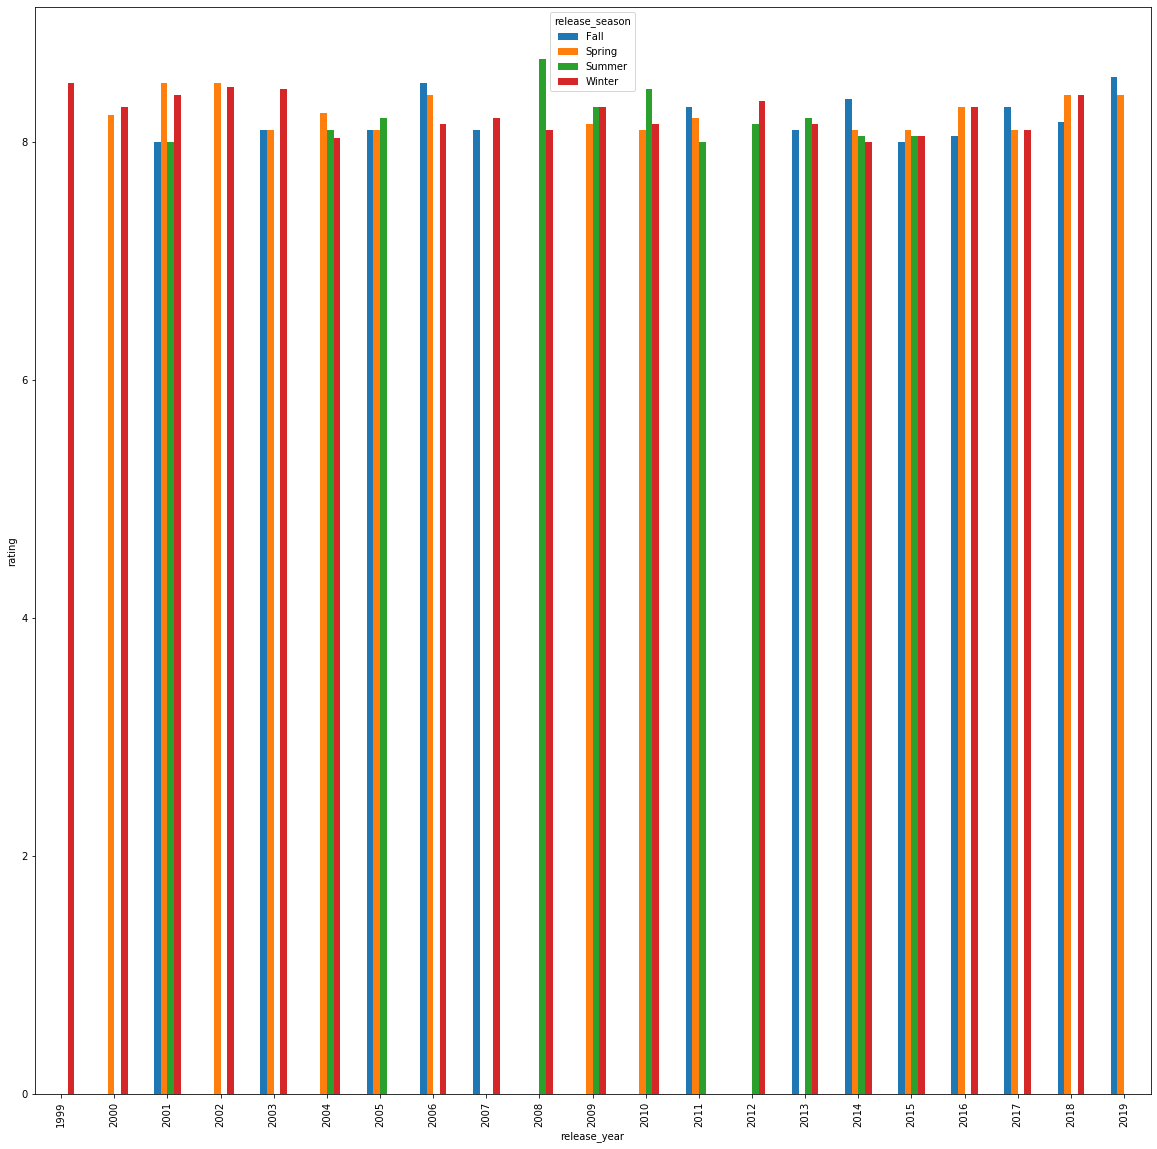

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

fall = [9, 10, 11]
winter = [12, 1, 2]
spring = [3, 4, 5]
summer =  [6, 7, 8]

def season(date):
    month = date.month
    if month in fall:
        return 'Fall'
    elif month in winter:
        return 'Winter'
    elif month in spring:
        return 'Spring'
    elif month in summer:
        return 'Summer'
    else:
        return ''

seasons = []    
last20 = datetime.now() - relativedelta(years=20)
df = merged.loc[merged['release_date'] >= last20,:].copy()
df['release_season'] = df['release_date'].apply(season)

counts = df.groupby(['release_year', 'release_season'])['rating'].count()
means = df.groupby(['release_year', 'release_season'])['rating'].mean()
plot = means.unstack().plot.bar(figsize=(20,20)).set_ylabel('rating')

## Genre and Directors

Create two pie charts in a figure next to each other. In one, plot the number of movies in each genre and in the other, plot the number of movies directed by each director. Since there are many directors only keep the people who have directed 3 movies or more. First create two dataframes for the charts. One should have two columns:
* genre (set as **index**)
* count_ratings
* mean_ratings (**sort the dataframe** by this column in decending order)

and the other one:
* name (set as **index**)
* count_movies (**sort the dataframe** by this column in decending order)

After making the dataframes you can proceed to drawing the two [pie charts](https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html#sphx-glr-gallery-pie-and-polar-charts-pie-features-py) based on them. Sorting the table before drawing the charts make the slices sorted, try drawing charts for the same data but comment out the line of code you wrote for sorting and see the difference. Make an appropriate title for each chart, also show the name of each genre/each director next to each pie slice. (20 points)

In [19]:
df = merged.copy()

genres = pd.DataFrame({
    col: np.repeat(df[col].values, df['genres'].str.len())
    for col in df.columns.drop('genres')
}).assign(**{'genres': np.concatenate(df['genres'].values)})[df.columns]
genre_stats = genres.groupby('genres').agg({
    'rating': ['count', 'mean']
})
genre_stats.columns = genre_stats.columns.droplevel(0)
genre_stats.rename(columns={'count': 'count_ratings', 'mean': 'mean_ratings'}, inplace = True)
genre_stats.sort_values(by='mean_ratings', inplace = True, ascending=False)
genre_stats

,count_ratings,mean_ratings
genres,,
Horror,5,8.400000
Western,6,8.366667
Fantasy,19,8.342105
Music,4,8.325000
Action,36,8.283333
Sci-Fi,24,8.279167
Family,13,8.276923
Adventure,57,8.270175
Crime,56,8.269643


In [20]:
directors = pd.DataFrame({
    col: np.repeat(df[col].values, df['directors'].str.len())
    for col in df.columns.drop('directors')
}).assign(**{'directors': np.concatenate(df['directors'].values)})[df.columns]
director_stats = directors.groupby('directors').agg({
    'name': 'count'
})
director_stats.columns = ['count_movies']
director_stats.index.names = ['name']
director_stats.sort_values(by='count_movies', inplace = True, ascending=False)
director_stats = director_stats[director_stats['count_movies'] >= 3] 
director_stats

,count_movies
name,
Christopher Nolan,7
Martin Scorsese,7
Stanley Kubrick,7
Steven Spielberg,6
Alfred Hitchcock,6
Hayao Miyazaki,6
Billy Wilder,6
Akira Kurosawa,5
Quentin Tarantino,5


Text(0, 0.5, '')

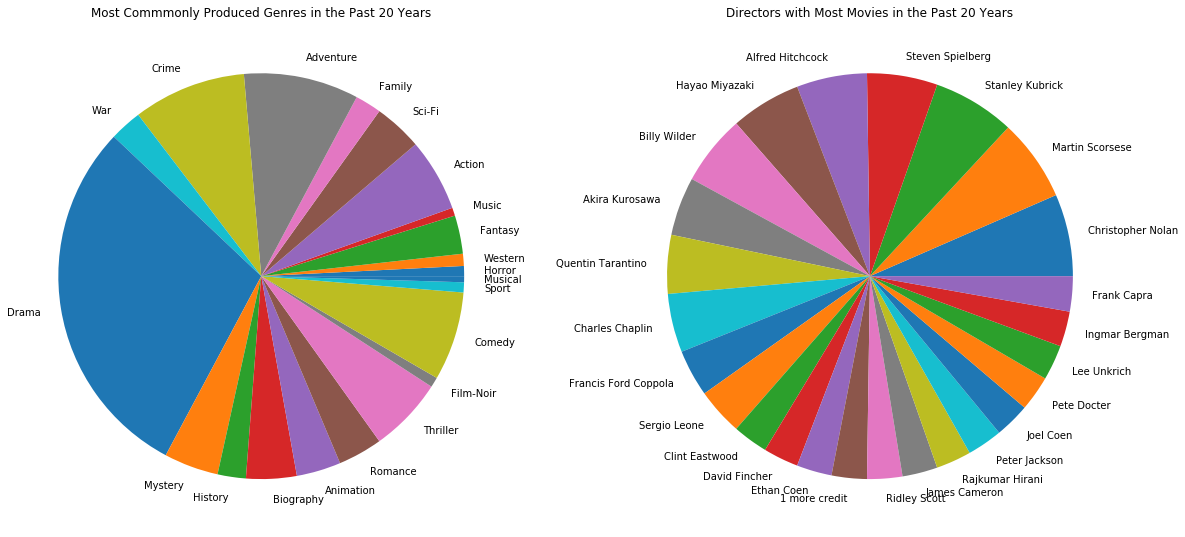

In [21]:
fig, (counts_axis, directors_axis) = plt.subplots(1, 2, figsize=(20, 10))
genre_stats.plot.pie(ax=counts_axis , y='count_ratings', legend=False)
director_stats.plot.pie(ax=directors_axis, y='count_movies', legend=False)
fig.set_facecolor('white')
counts_axis.set_title('Most Commmonly Produced Genres in the Past 20 Years')
counts_axis.set_ylabel('')
directors_axis.set_title('Directors with Most Movies in the Past 20 Years')
directors_axis.set_ylabel('')

## Budget

Make a scatter plot with movies length and budget as the x and y axes. Since the budgets are not adjusted for inflation, to approximate that, color code the data points so that the movies that are released in the same decade have the same color. Use `alpha` parameter to make the points 50% transparent so that overlapping points are better visible. Set the proper axis labels and chart title. Also add a `colorbar` to show which color is associated with which decade. (15 points)

In [34]:
def getDecade(year):
    last2 = year % 100;
    first2 = int(str(year)[:2]) * 100
    return first2 + (last2 - (last2 % 10))

df = merged.loc[:, ('name', 'release_year', 'budget', 'length')].copy()
df['decade'] = df['release_year'].apply(getDecade)
df.drop('release_year', axis=1, inplace=True)
df

,name,budget,length,decade
0,The Shawshank Redemption,25000000.0,142,1990
1,The Godfather,6000000.0,175,1970
2,The Godfather: Part II,13000000.0,202,1970
3,The Dark Knight,185000000.0,152,2000
4,12 Angry Men,350000.0,96,1950
...,...,...,...,...
247,Guardians of the Galaxy,170000000.0,121,2010
248,Infernal Affairs,6428966.0,101,2000
249,Aladdin,28000000.0,90,1990
250,The Battle of Algiers,800000.0,121,1960


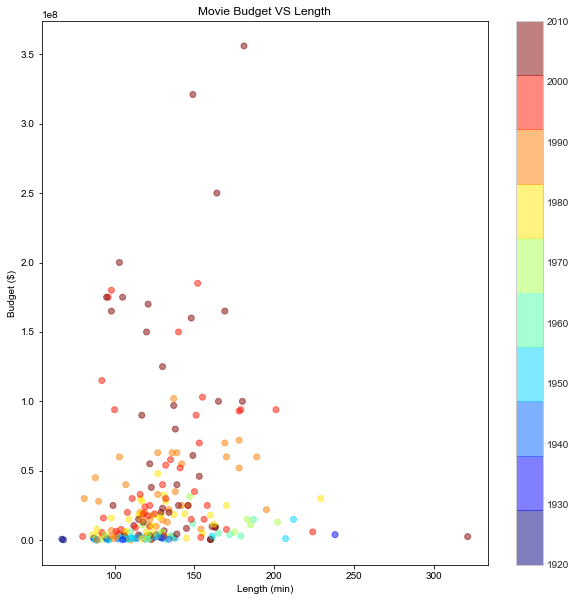

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.style.use('seaborn-whitegrid')

number_of_unique_decades = df.groupby('decade').ngroups
color_map = plt.get_cmap('jet', number_of_unique_decades)
ax.set_title('Movie Budget VS Length')
im = ax.scatter(df['length'], df['budget'], alpha=0.5, c=df['decade'], cmap=color_map)
ax.set_xlabel('Length (min)')
ax.set_ylabel('Budget ($)')
fig.colorbar(im, ax=ax)
plt.show()